In [1]:
#!pip install huffman

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
import cv2
import huffman
from collections import Counter

In [2]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

zigzag_template = [
        (0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
        (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
        (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
        (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
        (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
        (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
        (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
        (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)]


def matrix_to_zigzag(m):
    zigzag_iteration = [m[i, j] for i, j in zigzag_template]
    return zigzag_iteration


def zigzag_to_matrix(l):
    m = np.zeros((8, 8))
    for i in range(64):
        r, c = zigzag_template[i]
        m[r, c] = l[i]
    return m    




C:\Users\maria\AppData\Local\Temp\ipykernel_4196\72025482.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


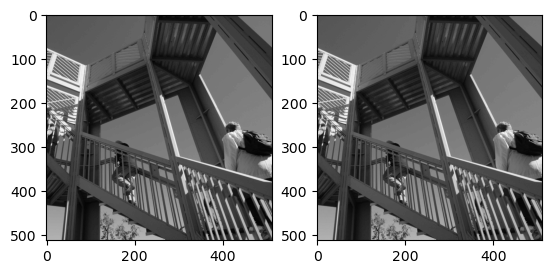

In [33]:
X = misc.ascent()

# sarcina 1

def jpeg_encoding(X):
    r, c = X.shape
    r8 = int(np.ceil(r/8) * 8)
    c8 = int(np.ceil(c/8) * 8)
    
    padding_r = r8 - r 
    padding_c = c8 - c
    
    X_ext = cv2.copyMakeBorder(X, 0, padding_c, 0, padding_r, cv2.BORDER_CONSTANT, value=0)
    
    # y_nnz = 0
    # y_jpeg_nnz = 0
    # Y_jpeg = np.zeros_like(X_ext)

    # luam pe rand fiecare bloc de 8x8 
    # ii facem dctn + cuantizare
    # parcurgem blocul in zig zag si concatenam raspunsurile de la fiecare bloc
    # aplicam huffman pe sirul concatenat

    zigzag_concatenat = []

    for i in range(int(r8/8)):
        for j in range(int(c8/8)):
            # extragerea blocului:
            x = X_ext[8*i:8*i + 8, 8*j:8*j + 8]

            # aplicarea dctn:
            y = dctn(x)
            # y_nnz += np.count_nonzero(y)

            # cuantizare:
            y_jpeg = Q_jpeg*np.round(y/Q_jpeg)
            # y_jpeg_nnz += np.count_nonzero(y_jpeg)

            # parcurgere zigzag:
            y_zigzag = matrix_to_zigzag(y_jpeg)
            
            # concatenare rezultat:
            zigzag_concatenat.extend(y_zigzag)
            # Y_jpeg[8*i:8*i + 8, 8*j:8*j + 8] = y_jpeg

    # TODO: Huffman coding

    
    # return Y_jpeg
    return list(map(int, zigzag_concatenat)), r8, c8



def jpeg_decoding(encoded_data, r, c):
    # TODO: Huffman decoding
    
    X_jpeg = np.zeros((r, c))
    matrix_list = []
    for i in range(int(len(encoded_data)/64)):
        # y = Y[8*i:8*i + 8, 8*j:8*j + 8]
        y = zigzag_to_matrix(encoded_data[i*64 : i*64+64])
        x_jpeg = idctn(y)

        matrix_list.append(x_jpeg)
    count = 0
    for i in range(int(r/8)):
        for j in range(int(c/8)):
            X_jpeg[8*i:8*i + 8, 8*j:8*j + 8] = matrix_list[count]
            count += 1
    
    return X_jpeg    
   

encoded_data, r, c = jpeg_encoding(X)
decoded_data = jpeg_decoding(encoded_data, r, c)

# print(np.array_equal(orig_jpeg, decoded_data))


plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.subplot(122).imshow(decoded_data, cmap=plt.cm.gray)
plt.show()

